In [66]:
import os
import random

from PIL import Image

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler 
from torchvision import transforms

import numpy as np

import pandas as pd

In [67]:
TRAIN_IMAGES_PATH = os.sep.join(["..", "resized_images"]) # относительный путь к папке с картинками

CSV_PATH = "sample_full.csv"

IMAGE_NORMAL_SIZE = (224, 224)
GRAM_SIZE = 512

RANDOM_SEED = 4545435
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CPU = torch.device("cpu")

In [68]:
class MyCustomDataset(Dataset):
    def __init__(self, dict_path):
        self.transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.class_dict = pd.read_csv(dict_path)
        
    def __getitem__(self, index):
        row = self.class_dict.iloc[index]
        file_path = row[1]
        
        data = Image.open(file_path).convert("RGB").resize(IMAGE_NORMAL_SIZE)
        data = self.transformations(data)  # (3)
        
        label = row[2]
        
        return data, label

    def __len__(self):
        return self.class_dict.index.shape[0]
    

class StyleMatrix(nn.Module):
    def __init__(self):
        super(StyleMatrix, self).__init__()

    def forward(self, input_):
         return __class__.gram_matrix(input_)
    
    @staticmethod
    def gram_matrix(inp): # исправленная версия
        a, b, c, d = inp.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c, d)=dimensions of a f. map (N=c*d)

        features = inp.view(a, b, c * d)  # resise F_XL into \hat F_XL
        G = torch.empty((a, b, b))
        for i in range(a):
            G[i] = torch.mm(features[i], features[i].t())

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

## Урезанная сеть ResNet18

In [69]:
full_vgg19 = models.vgg19(pretrained=True).features.to(DEVICE)
our_vgg19 = torch.nn.Sequential(*list(full_vgg19.children())[:-8]+[StyleMatrix()])
torch.save(full_vgg19.state_dict(), "our_vgg19.pth") # на случай, если придется пересохранять сетку
# our_vgg19.load_state_dict(torch.load("our_vgg19.pth"))
our_vgg19.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [70]:
network = our_vgg19

## Создание списка всех изображений (номер - путь к файлу - класс) 
### Аргументы:  
**file_path**-название результирующего файла,  
**cut_factor**-как "порезать" датасет (cut_factor=2 будет выбирать только каждую 2 картинку.  
Чем больше cut_factor-тем меньше датасет, выбрать полный датасет-cut_factor=1)

In [71]:
def generate_csv_classes(file_path, cut_factor=1):
    header = "filename,full_filename,num_class"
    data = header + "\n"
    
    timeframes = os.listdir(TRAIN_IMAGES_PATH)
    
    with open(file_path, "w+") as file_csv:
        for count_class, timeframe in enumerate(timeframes):
            timeframe_images_path = TRAIN_IMAGES_PATH+ os.sep + timeframe
            images = os.listdir(timeframe_images_path)
            img_count = 0
            for image_name in images:
                img_count+=1
                if img_count % cut_factor == 0: 
                    image_index = image_name.split(".")[0]
                    image_path = timeframe_images_path + os.sep + image_name
                    count_class_this = "0" if count_class <= 16 else str(count_class-16)
                    data += "{},{},{}\n".format(image_index, image_path, count_class_this)
                
        file_csv.write(data)
CUT_FACTOR = 1
generate_csv_classes(CSV_PATH, cut_factor=CUT_FACTOR)

## Загрузчики данных

In [72]:
VALIDATION_SPLIT = 0.4
TEST_SPLIT = 0.5
BATCH_SIZE = 5

In [73]:
data = MyCustomDataset(CSV_PATH)

dataset_size = len(data) 
indices = list(range(dataset_size)) 

split = int(VALIDATION_SPLIT * dataset_size)

np.random.seed(RANDOM_SEED) 
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices) 
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(data, batch_size=BATCH_SIZE, num_workers=0, sampler=train_sampler)

val_loader = DataLoader(data, batch_size=BATCH_SIZE, num_workers=0, sampler=valid_sampler)

print("Number of batches in train loader: {} ({} images)".format(len(train_loader), len(train_loader) * BATCH_SIZE))
print("Number of batches in validation loader: {} ({} images)".format(len(val_loader), len(val_loader) * BATCH_SIZE))

Number of batches in train loader: 3747 (18735 images)
Number of batches in validation loader: 2498 (12490 images)


## Отбор признаков (можно пропустить)
Каждую итерацию исключается ровно половина признаков, выявление наиболее важных происходит на 500, 1000, ... объектах в зависимости от текущего количества неисключенных признаков. В конце остаётся ~4000, которые можно сохранить в csv или продолжить работу.


In [74]:
N_BATCHES = len(train_loader)
MAX_FEATURES = 8000

In [75]:
from sklearn.feature_selection import SelectKBest, chi2

def select_features(loader, model, mask, n_batches, k):
    X = []
    y = []
    for i, (images, labels) in enumerate(loader):
        if i > n_batches:
            break
        actual_batch_size = min(images.shape[0], BATCH_SIZE)
        G_matrices = model(torch.reshape(images, (actual_batch_size, 3, *IMAGE_NORMAL_SIZE)).to(DEVICE))
        for j in range(actual_batch_size):
            X.append((G_matrices[j].cpu().detach().numpy().reshape((1, GRAM_SIZE*GRAM_SIZE))[0][mask] + 1) / 2)
        y += labels.tolist()
        if (i % 500) == 0:
            print(i, "batches out of", n_batches, "completed")
    selector = SelectKBest(chi2, k=k)
    selector.fit(X, y)
    print("Selected", k, "features from", len(mask), "with", n_batches*BATCH_SIZE, "objects")
    return mask[list(selector.get_support(indices=True))]

In [76]:
# mask_history = []
mask = np.array([i for i in range(GRAM_SIZE*GRAM_SIZE)])

start_time = time.time()
mask = select_features(train_loader, network, mask, N_BATCHES // 4, MAX_FEATURES * 4)
print((time.time() - start_time), 'seconds spent\n')
mask = select_features(train_loader, network, mask, N_BATCHES, MAX_FEATURES)
print((time.time() - start_time), 'seconds spent\n')

# while len(mask) > MAX_FEATURES:
#     start_time = time.time()
#     actual_n_batches = N_BATCHES
#     mask = select_features(train_loader, our_resnet_18, mask, actual_n_batches, len(mask) // 2)
#     mask_history.append(mask)
#     print((time.time() - start_time), 'seconds spent\n')

0 batches out of 936 completed
500 batches out of 936 completed
Selected 32000 features from 262144 with 4680 objects
169.72338771820068 seconds spent

0 batches out of 3747 completed
500 batches out of 3747 completed
1000 batches out of 3747 completed
1500 batches out of 3747 completed
2000 batches out of 3747 completed
2500 batches out of 3747 completed
3000 batches out of 3747 completed
3500 batches out of 3747 completed
Selected 8000 features from 32000 with 18735 objects
861.0879924297333 seconds spent



Сохраним номера признаков на разных шагах в файл на случай их утери.

In [77]:
from numpy import asarray, save

save('features_vgg_kbest.npy', asarray(mask))

In [78]:
# from numpy import asarray, save

# save('features_resnet_65000.npy', asarray(mask_history[-4]))
# save('features_resnet_32000.npy', asarray(mask_history[-3]))
# save('features_resnet_16000.npy', asarray(mask_history[-2]))
# save('features_resnet_8000.npy', asarray(mask_history[-1]))

## Пути к файлам

In [79]:
FEATURES_MASK_PATH = "features_vgg_kbest.npy" # путь к файлу с маской признаков (в данном случае на 8192 штуки)
TRAIN_CSV_PATH = "train.csv"
VALIDATION_CSV_PATH = "val.csv"
TEST_CSV_PATH = "test.csv"

## Перегонка картинок в их признаковое описание
Выполнение этого блока необходимо, если у вас нет сконвертированных данных в .csv

Если таковые есть, то этот блок стоит пропустить

In [80]:
mask = np.load(FEATURES_MASK_PATH)
print("Number of selected features:", len(mask))

Number of selected features: 8000


In [81]:
def get_features_dataset(loader, features, model):
    X = []
    y = []
    size = len(loader)
    for i, (images, labels) in enumerate(loader):
        actual_batch_size = min(images.shape[0], BATCH_SIZE)
        G_matrices = model(torch.reshape(images, (actual_batch_size, 3, *IMAGE_NORMAL_SIZE)).to(DEVICE))

        for j in range(actual_batch_size):
            X.append(G_matrices[j].cpu().detach().numpy().reshape((1, GRAM_SIZE*GRAM_SIZE))[0][features])
        y += labels.tolist()
        if (i % 1000) == 0:
            print(i, "batches out of", size, "completed")
    print("Converting results to Pandas DataFrame...")
    df = pd.DataFrame(data=X)
    df["label"] = y
    print("Done.")
    return df

df_train = get_features_dataset(train_loader, mask, network)

0 batches out of 3747 completed
1000 batches out of 3747 completed
2000 batches out of 3747 completed
3000 batches out of 3747 completed
Converting results to Pandas DataFrame...
Done.


In [82]:
df_val = get_features_dataset(val_loader, mask, network)

0 batches out of 2498 completed
1000 batches out of 2498 completed
2000 batches out of 2498 completed
Converting results to Pandas DataFrame...
Done.


In [83]:
test_size = int(df_val.shape[0] * TEST_SPLIT)
df_test, df_val = df_val.iloc[:test_size, :], df_val.iloc[test_size:, :]

In [84]:
df_train.shape, df_val.shape, df_test.shape

((18735, 8001), (6245, 8001), (6245, 8001))

In [85]:
# # можно пропустить, если сохранение не требуется
# df_train.to_csv(TRAIN_CSV_PATH)
# print("Saved train data")

# df_val.to_csv(VALIDATION_CSV_PATH)
# print("Saved validation data")

# df_test.to_csv(TEST_CSV_PATH)
# print("Saved test data")

## Загрузка данных из CSV файлов
Этот блок необходимо выполнить, если был пропущен предыдущий

In [86]:
# df_train = pd.read_csv(TRAIN_CSV_PATH)
# print("Loaded train data")

# df_val = pd.read_csv(VALIDATION_CSV_PATH)
# print("Loaded validation data")

# df_test = pd.read_csv(TEST_CSV_PATH)
# print("Loaded test data")

## Обучение и тестирование моделей

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, mean_squared_error, mean_squared_log_error, confusion_matrix, plot_confusion_matrix
import joblib

In [88]:
X_train = df_train.loc[:, df_train.columns != "label"]
X_test = df_test.loc[:, df_test.columns != "label"]
X_val = df_val.loc[:, df_val.columns != "label"]

y_train = df_train["label"]
y_test = df_test["label"]
y_val = df_val["label"]

In [89]:
# def replace_1300(y): # объединение малочисленных классов (теперь не обязателно (можно будет удалить))
#     for i in y.index:
#         y[i] = max(y[i], 16)
        
# replace_1300(y_train)
# replace_1300(y_test)
# replace_1300(y_val)

## PCA (не тестировалось, может долго работать)

In [97]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4000, svd_solver='randomized')
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

## Используем SGD

In [98]:
sgd = SGDClassifier(n_jobs=-1, verbose=0)
sgd.fit(X_train, y_train)

SGDClassifier(n_jobs=-1)

Number of train examples: 18735
0.3638110488390713
8.321377101681344


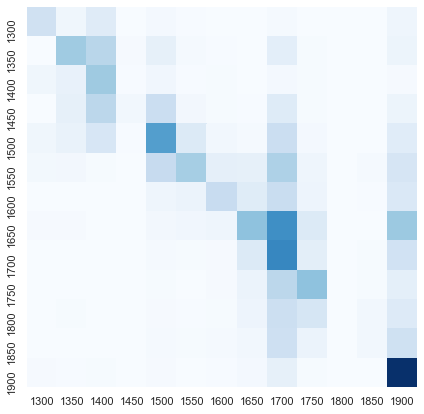

In [99]:
sgd_predict = sgd.predict(X_val)
print("Number of train examples:", len(train_loader) * BATCH_SIZE )
print(f1_score(y_val, sgd_predict, average="micro"), mean_squared_error(y_val, sgd_predict), sep="\n")

cmat = confusion_matrix(y_val, sgd_predict)
plt.figure(figsize=(7, 7))
sns.heatmap(
    cmat / np.sum(cmat, axis=1),
    annot=False, cbar=False,
    xticklabels=[1300 + i*50 for i in range(13)],
    yticklabels=[1300 + i*50 for i in range(13)],
    cmap="Blues") 
plt.show()

## Используем SVM

In [100]:
linear_svc = LinearSVC(verbose=2, max_iter=1000)
linear_svc.fit(X_train, y_train)

[LibLinear]

LinearSVC(verbose=2)

Number of train examples: 18735
0.44163330664531625
5.786549239391513


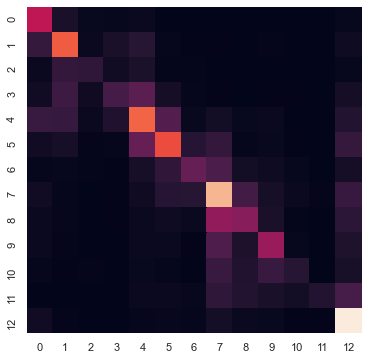

In [102]:
svc_predict = linear_svc.predict(X_test)
print("Number of train examples:", len(train_loader) * BATCH_SIZE )
print(f1_score(y_test, svc_predict, average="micro"), mean_squared_error(y_test, svc_predict), sep="\n")

cmat = confusion_matrix(y_test, svc_predict)
plt.figure(figsize=(6,6))
sns.heatmap(
    cmat / np.sum(cmat, axis=1),
    annot=False, cbar=False)
plt.show()

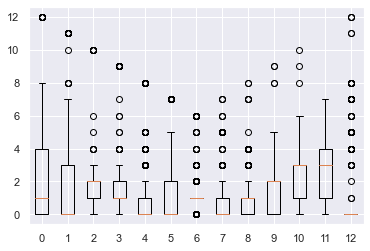

{'whiskers': [<matplotlib.lines.Line2D at 0x2dc84fbc6d0>,
 'caps': [<matplotlib.lines.Line2D at 0x2dc84fbcd90>,
 'boxes': [<matplotlib.lines.Line2D at 0x2dc84fbc370>],
 'medians': [<matplotlib.lines.Line2D at 0x2dc84fac490>],
 'fliers': [<matplotlib.lines.Line2D at 0x2dc84fac820>],
 'means': []}

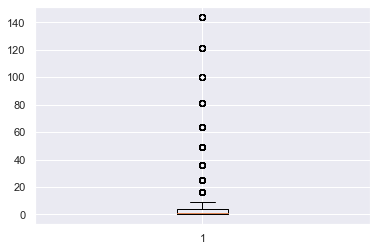

In [95]:
from sklearn.metrics import f1_score, mean_squared_error, mean_squared_log_error, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
NUM_OF_CLASSES = 13
print()
#[np.where(y_test==16)])
squared_error = np.power(y_test-svc_predict, 2)
squared_errors_by_classes = []
classes = list(range(NUM_OF_CLASSES))
for i in range(NUM_OF_CLASSES):
    index_mask = np.where(y_test==i)
    squared_errors_by_classes.append(
        np.power(
            np.power(y_test.values[index_mask]-svc_predict[index_mask], 2),
            1/2
        )
    )
plt.boxplot(squared_errors_by_classes, labels=classes)
plt.show()
plt.boxplot(squared_error)
